In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import re

In [3]:
def parseOutput(filename):
    
    outputs = []
    
    with open(filename,'r') as f:
        for line in f:
            if line.startswith('Epoch'):
                output = {}
                output['epoch'] = int(re.findall(r'Epoch\s*(\d*)',line)[0])
                output['train loss'] = float(re.findall(r'Train Batch Loss:\s*([\d\.]*)',line)[0])
                test_loss = re.findall(r'Test Loss:\s*([\d\.]*)',line)
                if test_loss:
                    output['test loss'] = float(test_loss[0])
                output['time'] = float(re.findall(r'Time elapsed:\s*([\d\.]*)',line)[0])
                
                outputs += [output]
    outputs = pd.DataFrame(outputs)
    return outputs

In [4]:
def tfr(epoch,max_tfr = 0.8):
    return max_tfr * np.sqrt(np.clip(1-epoch/(np.max(epoch)*0.8),0,np.inf))


In [5]:
single_layer_data = (parseOutput('Single_Layer_1.out'),
                         parseOutput('Single_Layer_2.out'),
                         parseOutput('Single_Layer_3.out'))

all_single_layer_df = pd.concat(single_layer_data,ignore_index=True)

In [6]:
double_layer_data = (parseOutput('Double_Layer_1.out'),
                         parseOutput('Double_Layer_2.out'),
                         parseOutput('Double_Layer_3.out'))
all_double_layer_df = pd.concat(double_layer_data,ignore_index=True)

In [7]:
NDStack = parseOutput('NDStack.out')

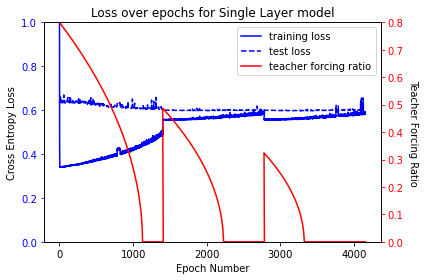

In [8]:
fig,ax = plt.subplots()

h1 = ax.plot(all_single_layer_df['epoch'],all_single_layer_df['train loss'],'b-',label='training loss')
h2 = ax.plot(all_single_layer_df.dropna()['epoch'],all_single_layer_df.dropna()['test loss'],'b--',label='test loss')

tax = ax.twinx()
h3 = tax.plot(all_single_layer_df['epoch'],np.hstack([tfr(df['epoch']) for df in single_layer_data]),
              color='r',label='teacher forcing ratio')
tax.set_ylim((0,0.8))

handles = h1+h2+h3
labels = [h.get_label() for h in handles]
tax.legend(handles, labels,loc='upper right')

ax.tick_params(axis='y', colors='b')
tax.tick_params(axis='y', colors='r')

ax.set_ylabel('Cross Entropy Loss')
tax.set_ylabel('Teacher Forcing Ratio',rotation=-90,va='bottom')

ax.set_xlabel('Epoch Number')

ax.set_title('Loss over epochs for Single Layer model')
ax.set_ylim((0,1))

plt.tight_layout()
# plt.savefig('figs/single_layer.png',dpi=300,facecolor='white')
plt.show()

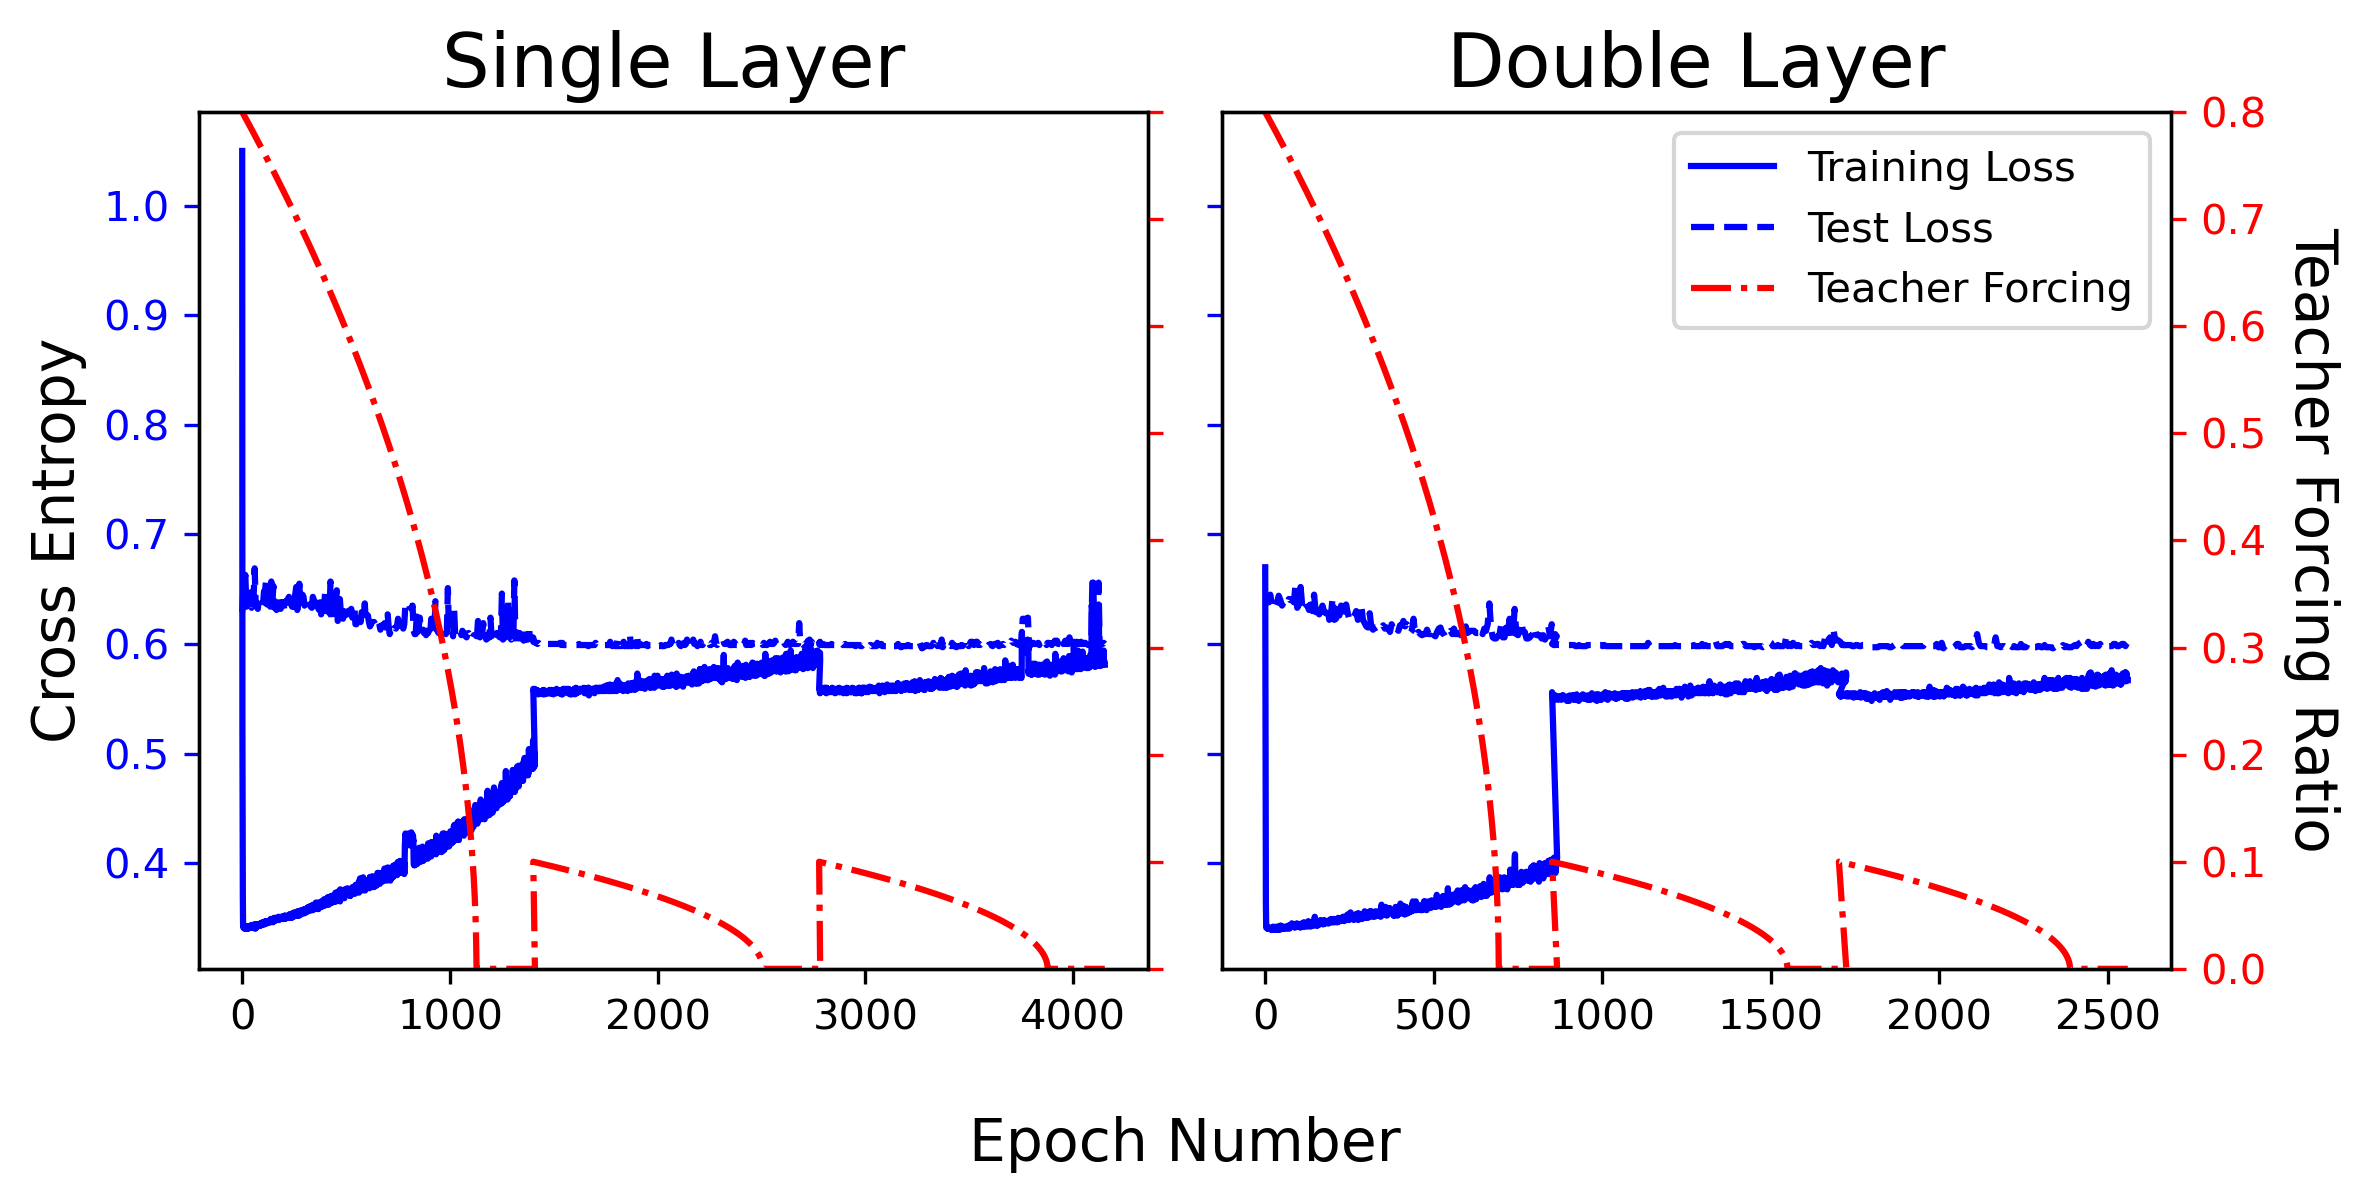

In [14]:
fig,axs = plt.subplots(ncols=2,facecolor='white',sharey=True,
                       figsize=(8,4),dpi=300)

for df,data,name,ax in zip([all_single_layer_df,all_double_layer_df],
                           [single_layer_data,double_layer_data],
                           ['Single','Double'],
                           axs):
    
    h1 = ax.plot(df['epoch'],df['train loss'],'b-',label='Training Loss')
    h2 = ax.plot(df.dropna()['epoch'],df.dropna()['test loss'],'b--',label='Test Loss')

    tax = ax.twinx()
    h3 = tax.plot(df['epoch'],np.hstack([tfr(df.sub(df.iloc[0,:])['epoch'],max_tfr=max_tfr) for df,max_tfr in zip(data,[0.8,0.1,0.1])]),'-.',
                  color='r',label='Teacher Forcing')
    tax.set_ylim((0,0.8))

    handles = h1+h2+h3
    labels = [h.get_label() for h in handles]
    tax.tick_params(axis='y', colors='r', labelright=False)
    


    ax.set_title(f"{name} Layer",fontsize=18)
#     ax.set_ylim((0,1))

    ax.tick_params(axis='y', colors='b')
axs[0].set_ylabel('Cross Entropy',fontsize=14)

tax.tick_params(axis='y', colors='r', labelright=True)
tax.set_ylabel('Teacher Forcing Ratio',rotation=-90,va='bottom',fontsize=14)

tax.legend(handles, labels,loc='upper right')

fig.supxlabel('Epoch Number',fontsize=14)


plt.tight_layout()
# plt.savefig('figs/single_layer.png',dpi=300,facecolor='white')
plt.show()

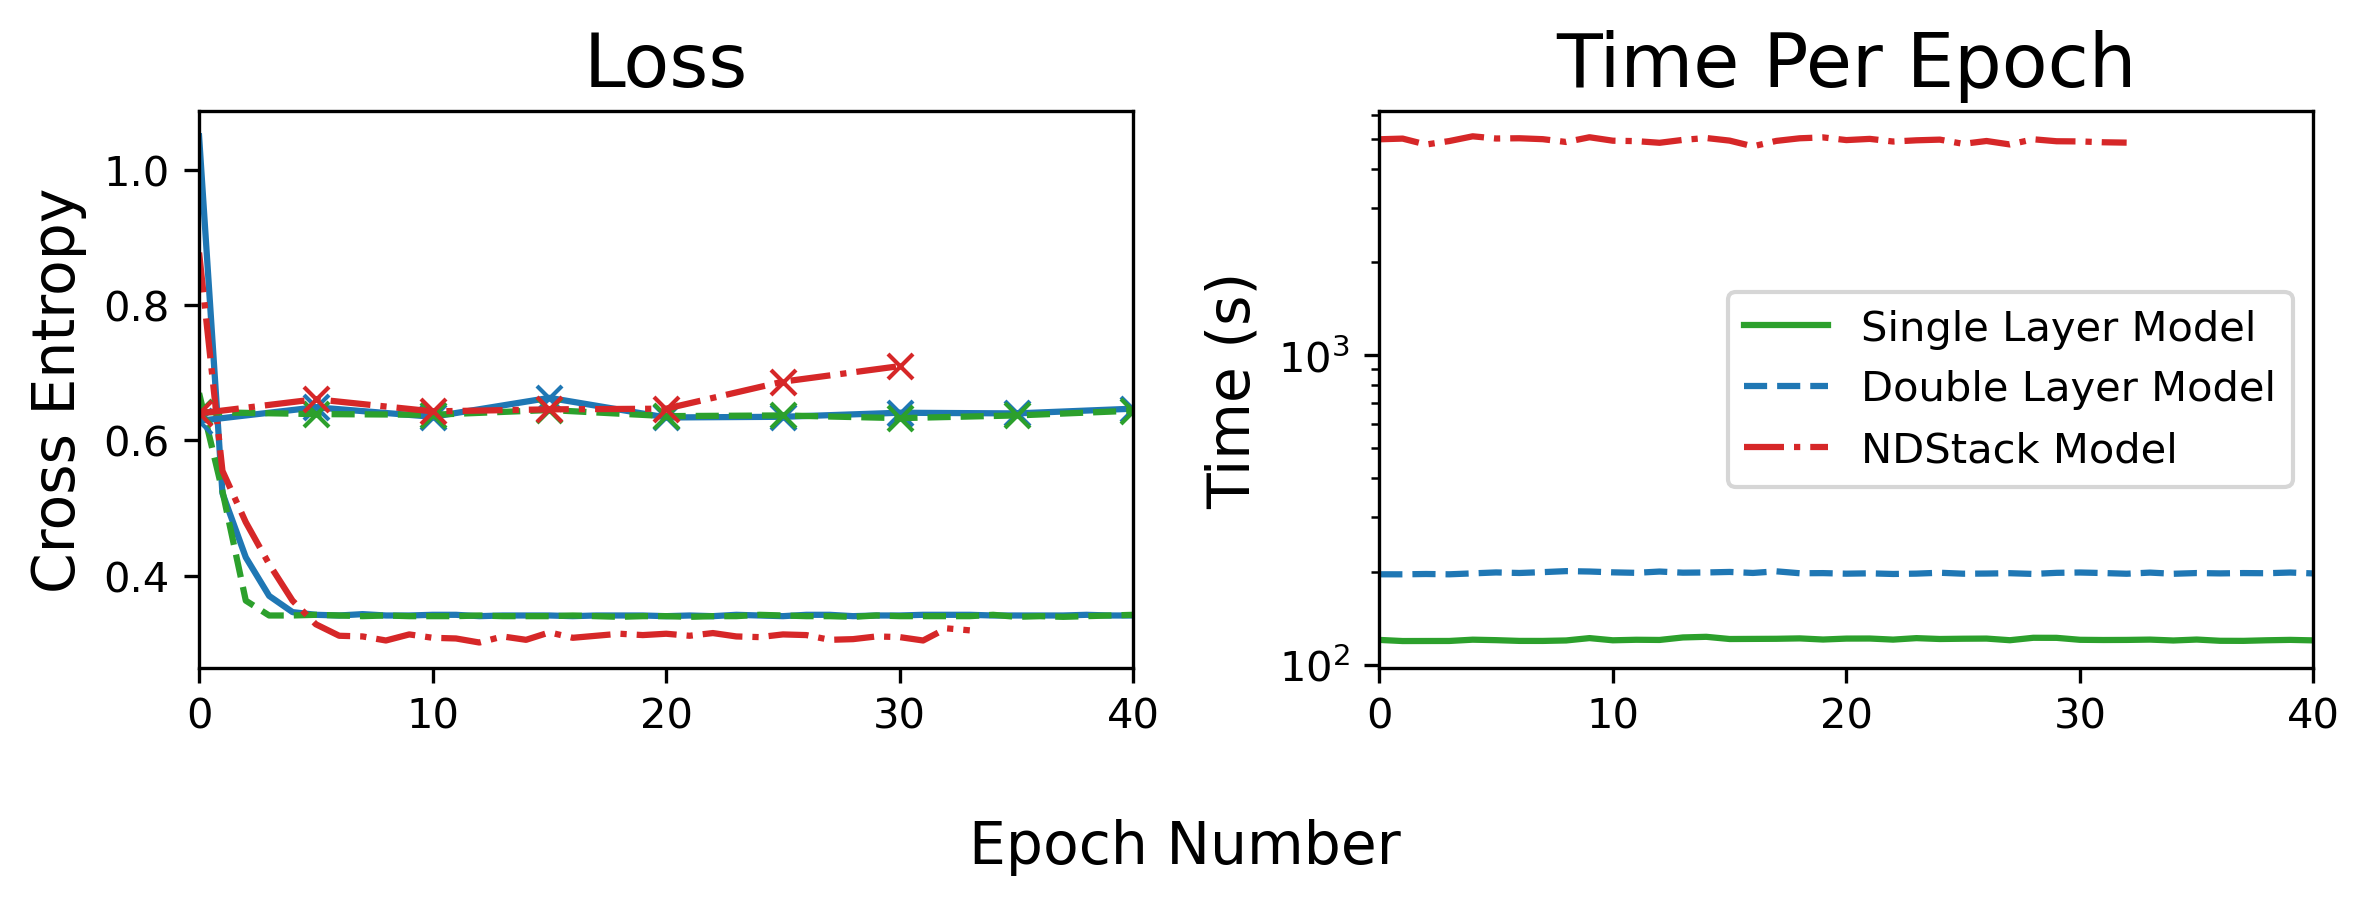

In [9]:
fig,axs = plt.subplots(ncols=2,figsize=(8,3),facecolor='white',sharex=True,dpi=300)

axs[0].plot(all_single_layer_df['epoch'],all_single_layer_df['train loss'],
            '-',color='tab:blue',label='Train')
axs[0].plot(all_double_layer_df['epoch'],all_double_layer_df['train loss'],
            '--',color='tab:green')
axs[0].plot(NDStack['epoch'],NDStack['train loss'],
            '-.',color='tab:red')

axs[0].plot(all_single_layer_df.dropna()['epoch'],all_single_layer_df.dropna()['test loss']
            ,'x-',label='Single Layer Model',color='tab:blue')
axs[0].plot(all_double_layer_df.dropna()['epoch'],all_double_layer_df.dropna()['test loss']
            ,'x--',color='tab:green')
axs[0].plot(NDStack.dropna()['epoch'],NDStack.dropna()['test loss']
            ,'x-.',color='tab:red')


axs[0].set_ylabel('Cross Entropy',fontsize=14)
axs[0].set_title('Loss',fontsize=18)

axs[1].plot(all_single_layer_df['epoch'].iloc[:-1],
        np.clip(np.diff(all_single_layer_df['time']),0,np.inf),
            '-',label='Single Layer Model',color='tab:green')
axs[1].plot(all_double_layer_df['epoch'].iloc[:-1],
        np.clip(np.diff(all_double_layer_df['time']),0,np.inf),
            '--',label='Double Layer Model',color='tab:blue')
axs[1].plot(NDStack['epoch'].iloc[:-1],np.diff(NDStack['time']),
            '-.',label='NDStack Model',color='tab:red')


axs[1].set_xlim((0,40))
axs[1].set_yscale('log')
axs[1].set_ylabel('Time (s)',fontsize=14)
axs[1].set_title('Time Per Epoch',fontsize=18)
axs[1].legend()

fig.supxlabel('Epoch Number',fontsize=14)

plt.tight_layout()
plt.show()

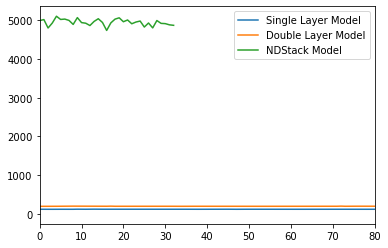

In [121]:
fig,ax = plt.subplots()

ax.plot(all_single_layer_df['epoch'].iloc[:-1],
        np.clip(np.diff(all_single_layer_df['time']),0,np.inf),label='Single Layer Model')
ax.plot(all_double_layer_df['epoch'].iloc[:-1],
        np.clip(np.diff(all_double_layer_df['time']),0,np.inf),label='Double Layer Model')
ax.plot(NDStack['epoch'].iloc[:-1],np.diff(NDStack['time']),label='NDStack Model')

ax.legend()

ax.set_xlim((0,80))

plt.show()